# Part3. Model Prediction

## Setting and Import

In [ ]:
# Global variables
ROUND = 103

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle

In [ ]:
from IPython.display import clear_output
!pip install transformers
!pip install sklearn_crfsuite
clear_output()

In [ ]:
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from sklearn_crfsuite.metrics import flat_classification_report

## Data Preprocessing

In [ ]:
# 輸入 test file 的路徑，會輸出 output.tsv，再從雲端硬碟下載下來上傳
testingset = list()  # store testingset [content,content,...]
with open('/content/drive/MyDrive/nlp_data_2/test.txt', 'r', encoding='utf8') as f:
    file_text = f.read().encode('utf-8').decode('utf-8-sig')
datas = file_text.split('\n\n--------------------\n\n')[:-1]
for data in datas:
    data = data.split('\n')
    # article_id = data[0]
    content = data[1]
    testingset.append(content)

In [ ]:
def split_sentence(data_list):
    # final word vector list
    new_sentence_list = list()
    for idx_list in range(len(data_list)):
        temp_list = list()
        sentence_list = [each[0] for each in data_list[idx_list]]
        while len(sentence_list) > 512:
            temp_list.append(sentence_list[:512])
            sentence_list = sentence_list.copy()[512:]
        temp_list.append(sentence_list)
        new_sentence_list.append(temp_list)
    return new_sentence_list

In [ ]:
# 這裡的 article_sentence_list 是巢狀的 list, 每篇文章一個 list
article_sentence_list = split_sentence(testingset)

In [ ]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
bert_model = BertModel.from_pretrained('bert-base-chinese')

In [ ]:
def get_lstm_x(sentence_list):
    i = 0
    for sentence in sentence_list:
        # get word embedding lists with generator
        # Handle char to embedding
        inputs = [tokenizer.convert_tokens_to_ids(text) for text in list(sentence)]
        padding_num = 512 - len(inputs)
        input_ids = torch.tensor([inputs+[0]*padding_num])
        token_type_ids = torch.tensor([[0]*512])
        attention_mask = torch.tensor([[1]*len(inputs)+[0]*padding_num])
        final_inputs = {'input_ids': input_ids, 'token_type_ids': token_type_ids, 'attention_mask': attention_mask}
        outputs = bert_model(**final_inputs).last_hidden_state[0]
        word_vector_list = [word.detach().numpy() for word in outputs]
        i += 1
        print(f"Bert Embedding Finish: {i}/{len(sentence_list)}")
        yield np.array([word_vector_list])

In [ ]:
def get_crf_x(new_sentence_list, y_pred):
    # iterate 每個句子
    for idx_list in range(len(y_pred)):
        # 取得整個句子的 bert embedding vector
        sentence = new_sentence_list[idx_list]
        # 對句子中的每個字元建立 dict
        feature_list = list()
        # iterate 每個字
        for idx_tuple in range(len(y_pred[idx_list])):
            feature_dict = dict()
            # lstm output 特徵
            for idx_vec in range(len(y_pred[idx_list][idx_tuple])):
                feature_dict['lstm_dim_' + str(idx_vec)] = y_pred[idx_list][idx_tuple][idx_vec]
            # bert embedding 特徵
            # for idx_vec in range(len(word_vector_list[idx_tuple])):
            #     feature_dict['bert_dim_' + str(idx_vec)] = word_vector_list[idx_tuple][idx_vec]
            # one-gram, bigram and trigram 字元特徵
            for i in range(-3, 4):
                if len(sentence) > idx_tuple+i+2 > idx_tuple+i >= 0:
                    feature_dict['char_at_' + str(i)] = sentence[idx_tuple+i]
                    feature_dict['bigram_char_at_' + str(i)] = sentence[idx_tuple+i] + sentence[idx_tuple+i+1]
                    feature_dict['trigram_char_at_' + str(i)] = sentence[idx_tuple+i] + sentence[idx_tuple+i+1] + sentence[idx_tuple+i+2]
            feature_list.append(feature_dict)
        print(f"Finish prepare train x: {idx_list}/{len(y_pred)}")
        yield feature_list

## LSTM & CRF Prediction

In [ ]:
import numpy as np
import tensorflow
import keras
import keras.backend as K
from keras import Sequential, Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras.utils import plot_model

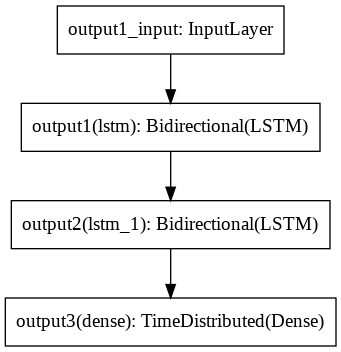

In [ ]:
# Load LSTM Model
bert_lstm_model = keras.models.load_model(f'/content/drive/MyDrive/nlp_data_2/lstm_model/bert_lstm_{ROUND}')
plot_model(bert_lstm_model)

In [ ]:
# Load CRF Model
with open(f"/content/drive/MyDrive/nlp_data_2/crf_model/crf_model_{ROUND}_7.pkl", "rb") as f:
    crf_model = pickle.load(f)

In [ ]:
# output 為最終結果要寫入的地方
output = "article_id\tstart_position\tend_position\tentity_text\tentity_type\n"
testdata_list = testingset[:]

In [ ]:
# 每篇文章輪流預測
article_id = 0
for sentence_list in article_sentence_list:
    # 取得該文章的 bert embedding
    lstm_x_test = get_lstm_x(sentence_list)
    # 餵入 LSTM 取得預測結果
    lstm_y_pred = bert_lstm_model.predict_generator(lstm_x_test, verbose=1, steps=len(sentence_list))
    # 從 LSTM 的預測結果萃取特徵
    crf_x_test = get_crf_x(sentence_list, lstm_y_pred)
    # 餵入 CRF 取得最終預測結果
    crf_y_pred = crf_model.predict(crf_x_test)
    # 串接單篇文章的所有預測標籤 # 同時把最後的 padding 部分移除
    crf_y_pred = [tag for sentence in crf_y_pred for tag in sentence][:len(testdata_list[article_id])]
    # 將預測結果寫入 output 字串
    start_pos = None
    end_pos = None
    entity_text = None
    entity_type = None
    carry_id = 0
    print("文章長度: ", len(testdata_list[article_id]))
    print("標籤長度: ", len(crf_y_pred))
    print("------------------------------------")
    for pred_id in range(len(crf_y_pred)-1):
        if crf_y_pred[pred_id][0] == 'B' and crf_y_pred[pred_id+1][0] != 'I':
            entity_type = crf_y_pred[pred_id][2:]
            entity_text = ''.join([testdata_list[article_id][position] for position in range(pred_id,pred_id+1)])
            line = str(article_id) + '\t' + str(pred_id) + '\t' + str(pred_id+1) + '\t' + entity_text + '\t' + entity_type
            output += line + '\n'
            start_pos = None
            end_pos = None
            entity_text = None
            entity_type = None
        elif crf_y_pred[pred_id][0] == 'B':
            start_pos = pred_id
            entity_type = crf_y_pred[pred_id][2:]
        elif start_pos is not None and crf_y_pred[pred_id][0] == 'I' and crf_y_pred[pred_id+1][0] != 'I':
            end_pos = pred_id
            entity_text = ''.join([testdata_list[article_id][position] for position in range(start_pos,end_pos+1)])
            line = str(article_id) + '\t' + str(start_pos) + '\t' + str(end_pos+1) + '\t' + entity_text + '\t' + entity_type
            output += line + '\n'
            start_pos = None
            end_pos = None
            entity_text = None
            entity_type = None
        carry_id = pred_id
    # 判斷文章中最後兩個字元
    if crf_y_pred[carry_id][0] == 'B' and crf_y_pred[carry_id+1][0] == 'I':
        entity_type = crf_y_pred[carry_id][2:]
        entity_text = ''.join([testdata_list[article_id][position] for position in range(carry_id,carry_id+2)])
        line = str(article_id) + '\t' + str(carry_id) + '\t' + str(carry_id+2) + '\t' + entity_text + '\t' + entity_type
        output += line + '\n' 
    if crf_y_pred[carry_id+1][0] == 'B':
        entity_type = crf_y_pred[carry_id+1][2:]
        entity_text = ''.join([testdata_list[article_id][position] for position in range(carry_id+1,carry_id+2)])
        line = str(article_id) + '\t' + str(carry_id+1) + '\t' + str(carry_id+2) + '\t' + entity_text + '\t' + entity_type
        output += line + '\n'
    if crf_y_pred[carry_id][0] == 'I' and crf_y_pred[carry_id+1][0] == 'I': 
        entity_type = crf_y_pred[carry_id][2:]
        entity_text = ''.join([testdata_list[article_id][position] for position in range(start_pos,carry_id+2)])
        line = str(article_id) + '\t' + str(start_pos) + '\t' + str(carry_id+2) + '\t' + entity_text + '\t' + entity_type
        output += line + '\n'
    article_id += 1
    print(f"Finish prediction of atricles: {article_id}/{len(article_sentence_list)}")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Bert Embedding Finish: 1/1
1/1 [==============================] - 3s 3s/step
Finish prepare train x: 0/1
文章長度:  507
標籤長度:  507
------------------------------------
Finish prediction of atricles: 1/159
Bert Embedding Finish: 1/3
3/3 [==============================] - 3s 1s/step
Finish prepare train x: 0/3
Finish prepare train x: 1/3
Finish prepare train x: 2/3
文章長度:  1055
標籤長度:  1055
------------------------------------
Finish prediction of atricles: 2/159
Bert Embedding Finish: 1/4
4/4 [==============================] - 5s 1s/step
Finish prepare train x: 0/4
Finish prepare train x: 1/4
Finish prepare train x: 2/4
Finish prepare train x: 3/4
文章長度:  1874
標籤長度:  1874
------------------------------------
Finish prediction of atricles: 3/159
Bert Embedding Finish: 1/2
2/2 [==============================] - 2s 964ms/step
Finish prepare train x: 0/2
Finish prepare train x: 1/2
文章長度:  945
標籤長度:  945
------------------------------------
Finish prediction of atricles: 4/159
Bert Embedding Finish

## Write Prediction to TSV File

In [ ]:
output_path = f'/content/drive/MyDrive/nlp_data_2/bert_lstm_crf_final_predict/blc_output_{ROUND}_7.tsv'
with open(output_path,'a',encoding='utf-8') as f:
    f.write(output)
print(output)

article_id	start_position	end_position	entity_text	entity_type
0	227	229	麻豆	location
0	237	239	麻豆	location
1	15	18	這學期	time
1	31	33	今天	time
1	40	42	昨天	time
1	76	80	0.79	med_exam
1	94	96	88	med_exam
1	111	113	60	med_exam
1	122	124	60	med_exam
1	179	181	20	med_exam
1	182	184	19	med_exam
1	258	261	2.6	med_exam
1	360	363	黃醫師	name
1	366	369	6.6	med_exam
1	385	388	6.6	med_exam
1	394	397	8.3	med_exam
1	407	410	8.3	med_exam
1	414	417	四個月	time
1	418	421	8.3	med_exam
1	463	466	6.2	med_exam
1	469	472	三個月	time
1	497	500	劉老師	name
1	742	744	中午	time
1	867	869	21	time
1	873	875	21	time
1	881	884	12天	time
1	890	893	12天	time
1	902	906	三個星期	time
2	170	174	1100	med_exam
2	245	249	1145	med_exam
2	275	278	500	med_exam
2	285	288	500	med_exam
2	390	393	三個月	time
2	402	405	三個月	time
2	678	680	55	med_exam
2	681	683	57	med_exam
2	699	701	52	med_exam
2	792	795	兩個月	time
2	1090	1094	7.56	med_exam
2	1151	1155	450塊	money
2	1239	1241	35	med_exam
2	1246	1248	35	med_exam
2	1394	1398	450塊	money
3	6	8	昨天	time
3	11	13	一天	tim